In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

from kedro.extras.datasets.pickle import PickleDataSet
from kedro.config import ConfigLoader

In [6]:
import os, sys
sys.path.append(os.path.abspath('..'))

from src.tagseg.data.acdc_dataset import AcdcDataSet
from src.tagseg.data.dmd_dataset import DmdDataSet
from src.tagseg.pipelines.data_splitting.nodes import split_data

In [3]:
conf_paths = ["../conf/base", "../conf/local"]
conf_loader = ConfigLoader(conf_paths)
conf_catalog = conf_loader.get("catalog*", "catalog*/**")

In [7]:
dataset = DmdDataSet(filepath='../' + conf_catalog['dmd_data']['filepath']).load()

In [5]:
dataset = PickleDataSet(filepath='../' + conf_catalog['acdc_data_tagged_only_myo']['filepath']).load()

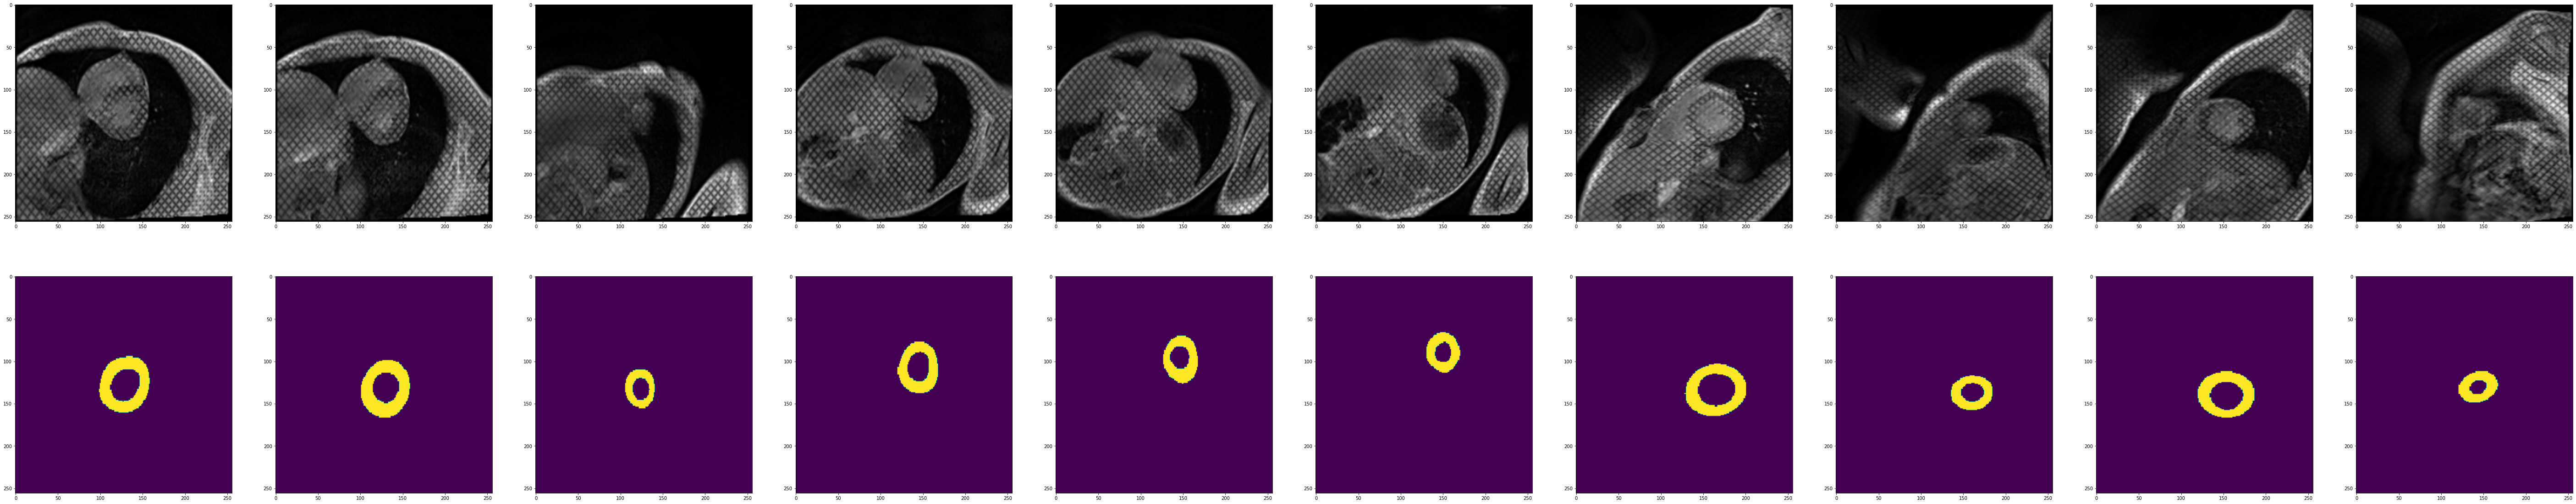

In [8]:
fig, ax = plt.subplots(2, 10, figsize=(100, 20))

for col in range(10):

    image, label = dataset[col]

    ax[0, col].imshow(image[0], cmap='gray')
    ax[1, col].imshow(label)

In [15]:
loaders = split_data(dataset, 0.75, 32)
loader_train, loader_val = loaders['loader_train'], loaders['loader_val']

In [19]:
images, labels = next(iter(loader_train))
images.shape, labels.shape

(torch.Size([32, 1, 256, 256]), torch.Size([32, 256, 256]))